In [1]:
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns

In [2]:
# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Check for GPU availability
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Set random seeds for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# ======= Hyperparams =======
epochs = 10
num_words = 15000
maxlen = 200  # Adjusted for shorter reviews
batch_size = 256
embedding_dim = 128  # Reduced since clothing reviews are typically shorter
hidden_dim = 256
num_layers = 2
dropout_prob = 0.15

# ======= Load & Preprocess =======
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text = ' '.join([w for w in word_tokens if w not in stop_words])
        return text
    else:
        return ""  # Return empty string for NaN values

# Load the dataset
df = pd.read_csv('ReviewTokoBaju.csv')

# Check if the dataset has the expected columns
print("Dataset columns:", df.columns.tolist())

# For this example, let's assume the dataset has 'Review Text' and 'Rating' columns
# Adjust these names according to your actual dataset column names
review_col = 'Review Text'
rating_col = 'Rating'

# Handle missing values
df[review_col] = df[review_col].fillna("")

# Preprocess reviews
df['processed_review'] = df[review_col].apply(preprocess_text)

# Convert ratings to binary sentiment (positive/negative)
# Assuming ratings are on a scale (e.g., 1-5), set threshold at midpoint
rating_threshold = 3
df['sentiment'] = (df[rating_col] > rating_threshold).astype(int)

# Build vocabulary from the dataset
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    # Sort words by frequency
    vocab = {word: idx+1 for idx, (word, _) in 
             enumerate(word_counts.most_common(max_words-1))}
    # Add padding token
    vocab['<PAD>'] = 0
    return vocab

# Create vocabulary
vocabulary = build_vocab(df['processed_review'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

# Convert texts to sequences
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # Use 0 for OOV words
    # Pad or truncate to maxlen
    if len(sequence) > maxlen:
        sequence = sequence[:maxlen]
    else:
        sequence = sequence + [0] * (maxlen - len(sequence))
    return sequence

# Create sequences
df['sequence'] = df['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

# Split data
X = np.array(df['sequence'].tolist())
y = np.array(df['sentiment'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"vocab_size: {vocab_size}, maxlen: {maxlen}")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset columns: ['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']
Vocabulary size: 15000
vocab_size: 15000, maxlen: 200


# RNN Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1920000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 256)         98560     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 256)         131328    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

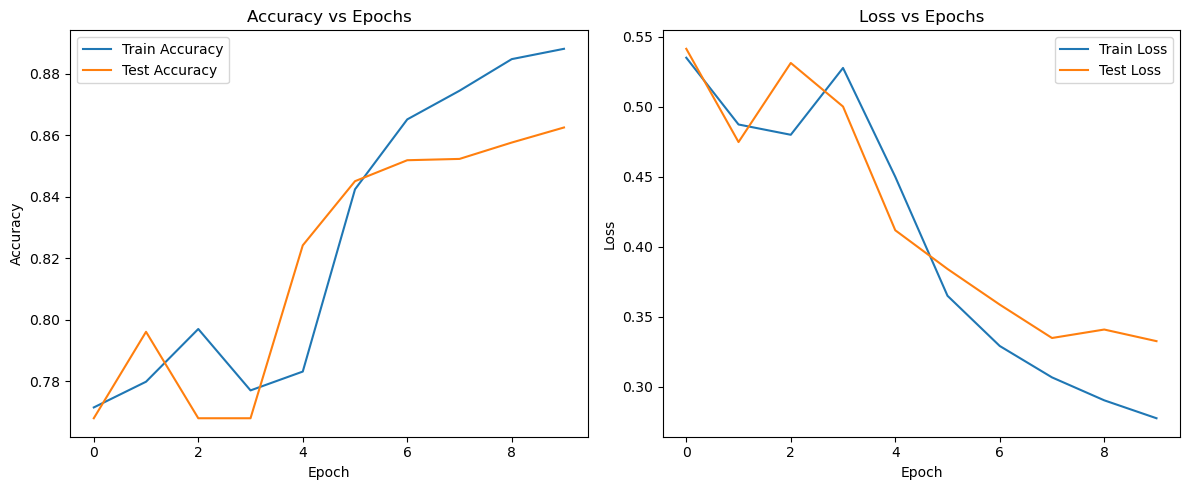

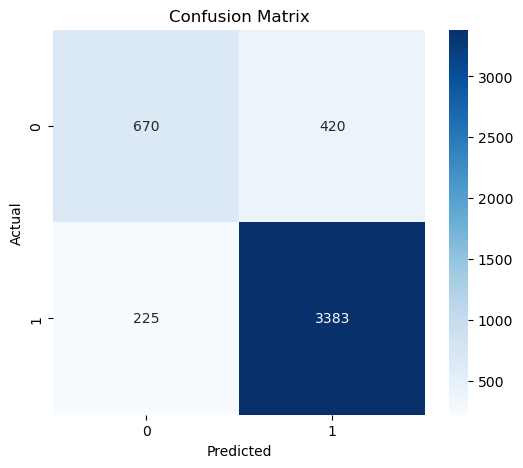

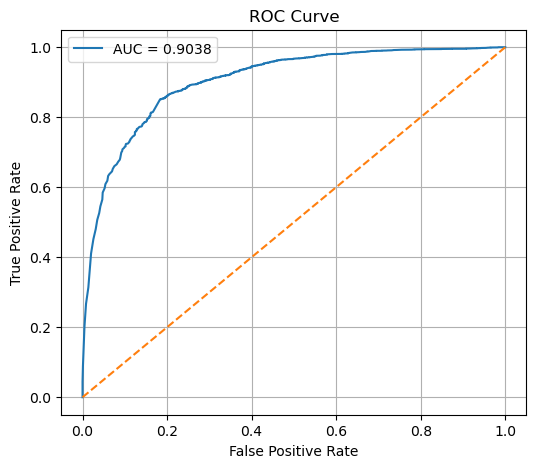


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: im normally size small store large tried still fits great oversized button threwonmyboyfriendsshirt ...
   True: 1, Pred: 1, Prob: 0.9658

2. Text: dress fits true sizing dress designer ie little large side compared dressmakers flattering made cott...
   True: 1, Pred: 1, Prob: 0.9731

3. Text: material soft cozy enough padding keep warm year round southern california ended leaving store witho...
   True: 0, Pred: 1, Prob: 0.9697

4. Text: leggings awesome quality especially price warm form fitting thick design nice plan wearing winter
   True: 1, Pred: 1, Prob: 0.9277

5. Text: luckily found store though backorder online really want go store effortless fun beautiful nicely det...
   True: 1, Pred: 1, Prob: 0.9707

6. Text: love love dress got regular size length petite side shorter im comfortable probably return
   True: 1, Pred: 1, Prob: 0.9707

7. Text: prettiest little nighty romantic soft pretty rea

In [3]:
# ======= Build TensorFlow SimpleRNN Model =======
def build_rnn_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))
    
    # Add SimpleRNN layers
    for i in range(num_layers - 1):
        model.add(SimpleRNN(hidden_dim, 
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))
    
    # Last RNN layer with return_sequences=False to get only the last output
    model.add(SimpleRNN(hidden_dim, 
                      return_sequences=True,
                      dropout=dropout,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))
    
    # Global Max Pooling to get the most important features
    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation="relu"))
    
    # Dropout before final layer
    model.add(Dropout(dropout))
    
    # Final dense layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='zeros'))
    
    return model

# Create the model
model = build_rnn_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Create callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# ======= Evaluate the model =======
# Get predictions
y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(n_samples=10):
    samples = []
    
    # Create reverse vocabulary for visualization
    idx_to_word = {idx: word for word, idx in vocabulary.items()}
    
    # Get some random samples from test set
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    for i in indices:
        # Get sequence and convert to text
        seq = X_test[i]
        words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
        text = ' '.join(words)
        
        # Get true and predicted values
        true_val = y_test[i]
        prob_val = model.predict(np.expand_dims(seq, axis=0))[0][0]
        pred_val = 1 if prob_val >= 0.5 else 0
        
        samples.append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true': true_val,
            'pred': pred_val,
            'prob': prob_val
        })
    
    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions()
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# LTSM Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1920000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 256)         394240    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

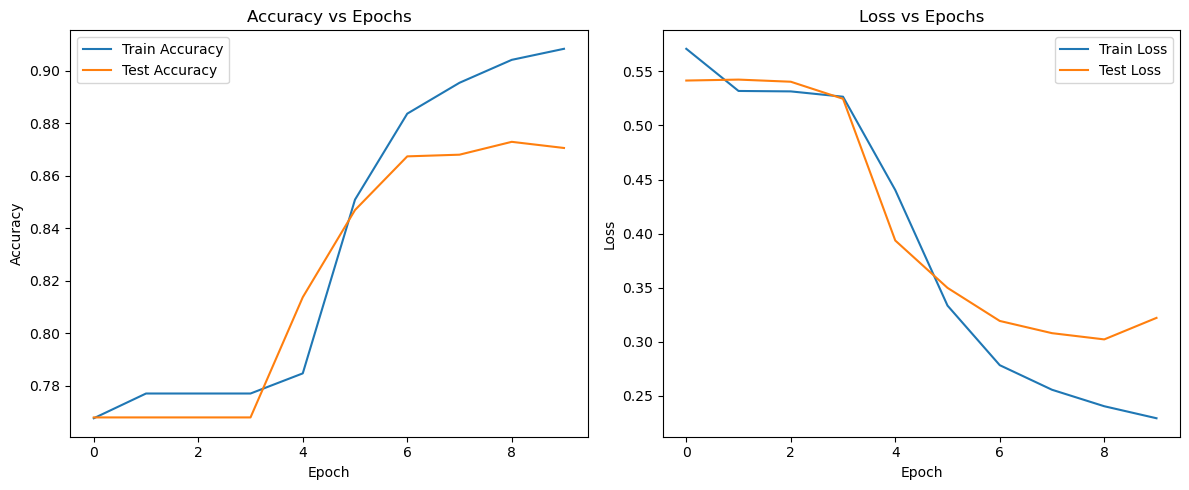

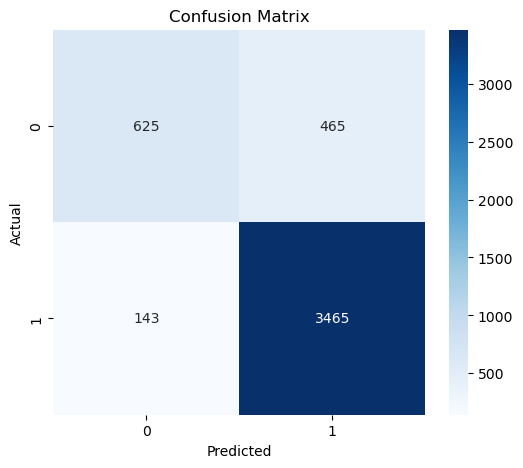

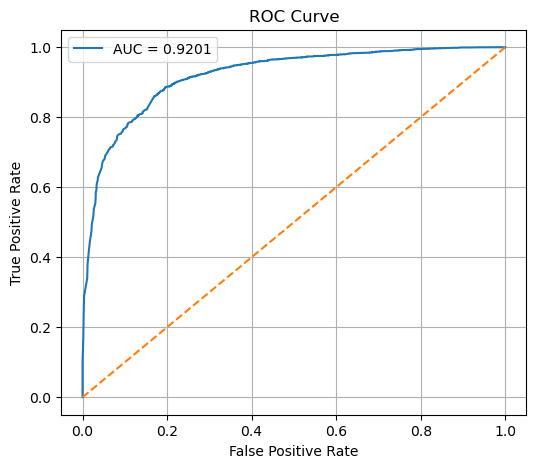


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: got white black print nice material pretty dress would preferred better cut overall pretty work dres...
   True: 1, Pred: 1, Prob: 0.8257

2. Text: dont know piece wide around body fabric good design way boxy get xsp still boxy
   True: 0, Pred: 0, Prob: 0.2166

3. Text: lbs extremely muscular ordered size large hangs nicely curves neckline looks pretty good broad shoul...
   True: 1, Pred: 1, Prob: 0.8647

4. Text: purchased sweater black dress everyday cardigan soft dress skirt great jeans
   True: 1, Pred: 1, Prob: 0.9922

5. Text: always hunt cute white tshirt one miss boxy short material thin price gave two stars nice colors spr...
   True: 0, Pred: 0, Prob: 0.4346

6. Text: looks pictured comfortable dressy love
   True: 1, Pred: 1, Prob: 0.9790

7. Text: super comfortable love feeling like im wearing pajamas public properly dressed although wear around ...
   True: 1, Pred: 1, Prob: 0.9731

8. Tex

In [4]:
# ======= Build TensorFlow LSTM Model =======
def build_lstm_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))
    
    # Add LSTM layers
    for i in range(num_layers - 1):
        model.add(LSTM(hidden_dim, 
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))
    
    # Last LSTM layer with return_sequences=False to get only the last output
    model.add(LSTM(hidden_dim, 
                      return_sequences=True,
                      dropout=dropout,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))
    
    # Global Max Pooling to get the most important features
    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation="relu"))
    
    # Dropout before final layer
    model.add(Dropout(dropout))
    
    # Final dense layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='zeros'))
    
    return model

# Create the model
model = build_lstm_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Create callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# ======= Evaluate the model =======
# Get predictions
y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(n_samples=10):
    samples = []
    
    # Create reverse vocabulary for visualization
    idx_to_word = {idx: word for word, idx in vocabulary.items()}
    
    # Get some random samples from test set
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    for i in indices:
        # Get sequence and convert to text
        seq = X_test[i]
        words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
        text = ' '.join(words)
        
        # Get true and predicted values
        true_val = y_test[i]
        prob_val = model.predict(np.expand_dims(seq, axis=0))[0][0]
        pred_val = 1 if prob_val >= 0.5 else 0
        
        samples.append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true': true_val,
            'pred': pred_val,
            'prob': prob_val
        })
    
    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions()
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# GRU Model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1920000   
_________________________________________________________________
gru (GRU)                    (None, None, 256)         296448    
_________________________________________________________________
gru_1 (GRU)                  (None, None, 256)         394752    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

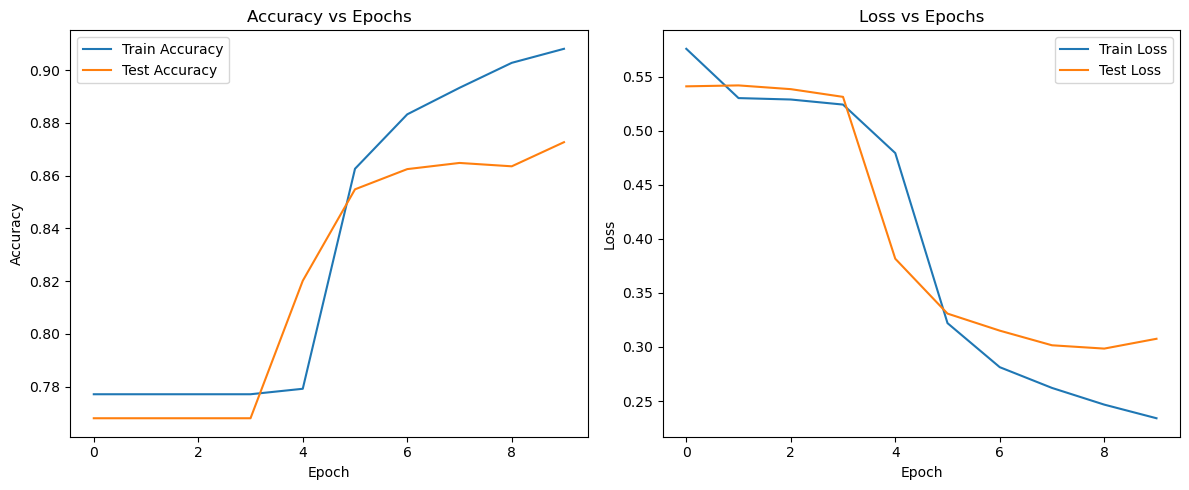

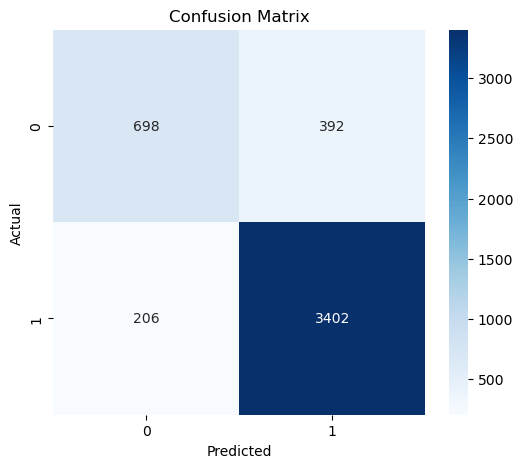

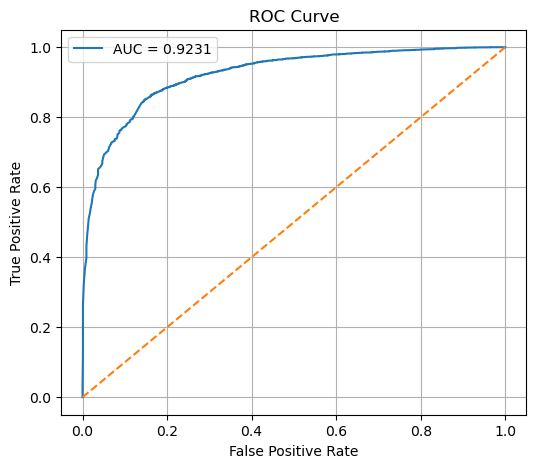


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: tank top fits well usually boarded large xl got large shirt perfect kind thin material wear white ta...
   True: 1, Pred: 1, Prob: 0.9941

2. Text: sweater matching tie belt detached belt loops im guessing previous reviewer accidentally threw away ...
   True: 1, Pred: 0, Prob: 0.1050

3. Text: find nearly perfect quality yet sturdy stitching unique based love theyre super machinewashable neve...
   True: 1, Pred: 1, Prob: 0.9863

4. Text: living alaska means fall starts early winter runs long great little skirt perfect casual fridays wee...
   True: 1, Pred: 1, Prob: 0.9980

5. Text: im obsessed cut style dont lot good jean options wear heels jeans amazing fit beautifully fabric qua...
   True: 1, Pred: 1, Prob: 0.8911

6. Text: im sure considered blue motif think black cream side great silk top warmer weather lightweight airy ...
   True: 1, Pred: 1, Prob: 0.9971

7. Text: prettiest little nighty roman

In [5]:
# ======= Build TensorFlow GRU Model =======
def build_gru_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))
    
    # Add GRU layers
    for i in range(num_layers - 1):
        model.add(GRU(hidden_dim, 
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))
    
    # Last GRU layer with return_sequences=False to get only the last output
    model.add(GRU(hidden_dim, 
                      return_sequences=True,
                      dropout=dropout,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))
    
    # Global Max Pooling to get the most important features
    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation="relu"))
    
    # Dropout before final layer
    model.add(Dropout(dropout))
    
    # Final dense layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='zeros'))
    
    return model

# Create the model
model = build_gru_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Create callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# ======= Evaluate the model =======
# Get predictions
y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(n_samples=10):
    samples = []
    
    # Create reverse vocabulary for visualization
    idx_to_word = {idx: word for word, idx in vocabulary.items()}
    
    # Get some random samples from test set
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    for i in indices:
        # Get sequence and convert to text
        seq = X_test[i]
        words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
        text = ' '.join(words)
        
        # Get true and predicted values
        true_val = y_test[i]
        prob_val = model.predict(np.expand_dims(seq, axis=0))[0][0]
        pred_val = 1 if prob_val >= 0.5 else 0
        
        samples.append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true': true_val,
            'pred': pred_val,
            'prob': prob_val
        })
    
    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions()
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# Penjelasan Model, Visualisasi, dan Metrik

## 1. RNN (Recurrent Neural Network)

RNN menggunakan mekanisme **recurrence** untuk mengolah data urut seperti teks atau waktu. Formula utama yang digunakan dalam RNN adalah:

### Persamaan Dasar:
- **State Update**:
  $$
  h_t = f(W_h \cdot h_{t-1} + W_x \cdot x_t + b)
  $$
  - **Penjelasan**:
    - \($h_t$\): State tersembunyi pada waktu \(t\).
    - \($x_t$\): Input saat waktu \(t\).
    - \($W_h$\), \($W_x$\): Matriks bobot untuk state sebelumnya dan input saat ini.
    - \($b$\): Bias.
    - \($f$\): Fungsi aktivasi (contoh: tanh atau ReLU).

### Alur:
Pada setiap langkah waktu, RNN memperbarui state tersembunyi \($h_t$\) menggunakan input saat itu \($x_t$\) dan state sebelumnya \($h_{t-1}$\).

---

## 2. LSTM (Long Short-Term Memory)

LSTM mengatasi masalah **vanishing gradient** yang sering dialami RNN dengan menggunakan **gate mechanism**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - **Fungsi**: Memutuskan informasi mana yang harus dibuang dari memori.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - **Fungsi**: Menghitung memori baru yang akan ditambahkan.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - **Fungsi**: Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - **Fungsi**: Menghitung keluaran berdasarkan state sel yang diperbarui.

---

## 3. GRU (Gated Recurrent Unit)

GRU adalah versi sederhana dari LSTM tanpa cell state terpisah. Persamaan yang digunakan:

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
   $$
   - **Fungsi**: Memutuskan informasi masa lalu yang harus dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
   $$
   - **Fungsi**: Mengontrol berapa banyak informasi dari masa lalu yang akan dibawa ke state saat ini.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$
   - **Fungsi**: State tersembunyi diperbarui menggunakan reset dan update gate.

---

## 4. Visualisasi

### Akurasi:
Akurasi dihitung sebagai:
$$
\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}}
$$

### Loss:
Loss dalam pelatihan model dihitung menggunakan fungsi **Binary Cross Entropy (BCE)**:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya.
- \($\hat{y}_i$\): Probabilitas prediksi model.

### ROC Curve:
ROC Curve menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**:
- **TPR**:
  $$
  TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
- **FPR**:
  $$
  FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
  $$

### AUC (Area Under Curve):
AUC mengukur area di bawah ROC Curve:
$$
\text{AUC} = \int_{0}^{1} TPR(FPR) \,dFPR
$$
Nilai AUC berkisar antara 0 hingga 1, dengan 1 menunjukkan prediksi sempurna.

---

## 5. Metrik

### Precision:
Precision mengukur seberapa tepat model dalam prediksi kelas positif:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

### Recall:
Recall mengukur kemampuan model untuk mendeteksi semua kelas positif:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

### F1 Score:
F1 Score adalah rata-rata harmonis antara precision dan recall:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Penjelasan Matematika TensorFlow (RNN, LSTM, GRU)

## 1. Embedding Layer
Layer **Embedding** digunakan untuk memetakan indeks kata menjadi representasi vektor terdistribusi yang dapat dipelajari:
$$
E(x_t) = W_{embedding} \cdot x_t
$$
- **Dimensi**:
  - \($x_t$\): Input berupa indeks kata, berukuran \($(\text{batch\_size}, \text{sequence\_length})$\).
  - \($W_{embedding}$\): Matriks bobot berukuran \($(\text{vocab\_size}, \text{embed\_dim})$\).
  - Output: Tensor berukuran \($(\text{batch\_size}, \text{sequence\_length}, \text{embed\_dim})$\).

Embedding ini secara otomatis diperbarui selama pelatihan untuk menghasilkan representasi semantik dari kata-kata.

---

## 2. Recurrent Neural Network (RNN)
RNN memproses data sekuensial dengan memanfaatkan hubungan temporal antar elemen.

### Persamaan Dasar:
$$
h_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$
- **Penjelasan**:
  - \($h_t$\): State tersembunyi pada waktu \($t$\).
  - \($W_{ih}$\): Bobot antara input dan state tersembunyi (\($embed\_dim \to hidden\_dim$\)).
  - \($W_{hh}$\): Bobot antara state tersembunyi sebelumnya (\($hidden\_dim \to hidden\_dim$\)).
  - \($b_h$\): Bias.
  - \($\text{tanh}$\): Fungsi aktivasi untuk mengontrol non-linearitas.

### Bidirectional RNN:
RNN dapat bersifat bidirectional, yang berarti memproses data dalam dua arah (maju dan mundur). Hal ini memungkinkan model untuk menangkap informasi dari konteks sebelum dan sesudah:
$$
h_t^{fwd} = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1}^{fwd} + b_h)
$$
$$
h_t^{bwd} = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t+1}^{bwd} + b_h)
$$
$$
h_t = [h_t^{fwd}, h_t^{bwd}]
$$
Di kode, RNN diganti dengan `layers.SimpleRNN`.

---

## 3. Long Short-Term Memory (LSTM)
LSTM adalah pengembangan dari RNN yang menggunakan mekanisme gate untuk menangani masalah **vanishing gradient**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - Mengontrol informasi mana yang harus dilupakan.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - Mengontrol informasi baru yang masuk ke memori.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - Mengontrol keluaran berdasarkan state sel yang diperbarui.

### Bidirectional LSTM:
Sama seperti RNN, LSTM dapat dibuat bidirectional untuk menangkap konteks sekuensial secara penuh.

Di kode, LSTM diimplementasikan menggunakan `layers.LSTM`.

---

## 4. Gated Recurrent Unit (GRU)
GRU adalah versi lebih ringan dari LSTM, dengan mekanisme gate yang lebih sederhana.

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_{r} \cdot [h_{t-1}, x_t] + b_{r})
   $$
   - Mengontrol seberapa banyak informasi lama yang dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_{z} \cdot [h_{t-1}, x_t] + b_{z})
   $$
   - Mengontrol seberapa banyak informasi baru yang ditambahkan.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_{h} \cdot [r_t \odot h_{t-1}, x_t] + b_{h})
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$

### Bidirectional GRU:
Bidirectional GRU menggunakan dua GRU, maju dan mundur, untuk memproses data sekuensial:
$$
h_t = [h_t^{fwd}, h_t^{bwd}]
$$
Di kode, GRU diimplementasikan menggunakan `layers.GRU`.

---

## 5. Global Max Pooling
Global Max Pooling mengubah sekuens menjadi representasi tetap:
$$
\text{GlobalMaxPool}(x) = \max(x_t), \forall t
$$
- **Dimensi**:
  - Input: \($(\text{batch\_size}, \text{sequence\_length}, \text{feature\_dim})$\).
  - Output: \($(\text{batch\_size}, \text{feature\_dim})$\).

---

## 6. Dense Layer
Dense layer digunakan untuk transformasi linier:
$$
y_t = W \cdot x_t + b
$$
- \($W$\): Matriks bobot (\($feature\_dim \to 1$\)).
- \($b$\): Bias.

Fungsi aktivasi seperti `sigmoid` digunakan untuk menghasilkan probabilitas:
$$
\hat{y}_t = \sigma(y_t)
$$

---

## 7. Binary Cross-Entropy Loss
Loss dihitung menggunakan:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label benar (0 atau 1).
- \($\hat{y}_i$\): Probabilitas prediksi.

---

## 8. Gradient Clipping
Gradient clipping digunakan untuk menghindari exploding gradients:
$$
\text{Gradient Clipping: } g_i = \min\big(g_i, \text{threshold}\big)
$$
- Memastikan gradient berada dalam batas tertentu.

---